    result  table                             time  N2K_wind_speed  \
0  _result      0 2024-09-17 10:00:00.009000+00:00            6.84   
1  _result      0 2024-09-17 10:00:00.048000+00:00            6.84   
2  _result      0 2024-09-17 10:00:00.088000+00:00            6.84   
3  _result      0 2024-09-17 10:00:00.128000+00:00            6.84   
4  _result      0 2024-09-17 10:00:00.168000+00:00            6.84   

   3FS_total_force  
0             69.0  
1             68.0  
2             67.0  
3             66.0  
4             65.0  
79738


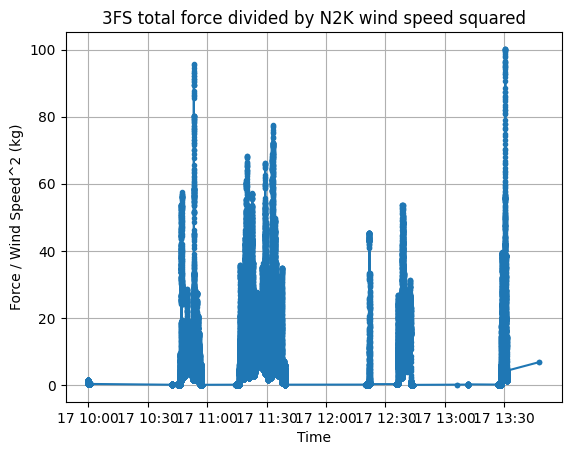

In [6]:
import influxdb_client
from influxdb_client.client.write_api import SYNCHRONOUS
import pandas
import matplotlib.pyplot as plt

# Server parameters, no need to modify
bucket = "le_seakite"
org = "beyond"
token = "52AzcESH6d6Uq1wymAF7lPZYAhW4NZMPxoaTdUrjuiD1htlFm69Z5tknxVrhLcO9WE7B8mIETTHaPh_H_iJhZA=="
url="http://vps-5df6f60f.vps.ovh.net:8086"
client = influxdb_client.InfluxDBClient(
    url=url,
    token=token,
    org=org
)
query_api = client.query_api()

# Utily functions
def generate_filter_string(modes):
    conditions = ' or '.join([f'r["mode"] == "{mode}"' for mode in modes])
    filter_string = f'|> filter(fn: (r) => {conditions})'
    return filter_string

def generate_field_filter_string(fields):
    conditions = ' or '.join([f'r["_field"] == "{field}"' for field in fields])
    filter_string = f'|> filter(fn: (r) => {conditions})'
    return filter_string

# Query parameters, can be modified
start = "2024-09-17T10:00:00Z" #UTC time
stop = "2024-09-17T19:00:00Z" #UTC time
modes = [ "Manual",] # case sensitive
fields = ["3FS_total_force", "N2K_wind_speed"]

# Specify a period under 40ms will instead retrieve all the data wihout any interpolation
period = "1ms" # can be "1ms", "10s", "9m", "3h" etc.

# Perform the query
query = f'from(bucket: "le_seakite")\
        |> range(start: {start}, stop: {stop})\
        {generate_filter_string(modes)}\
        {generate_field_filter_string(fields)}\
        |> aggregateWindow(every: {period}, fn: mean, createEmpty: false)\
        |> drop(columns: ["_start", "_stop"])\
        |> group()\
        |> sort(columns: ["_time"], desc: false)\
        |> pivot(rowKey:["_time"], columnKey: ["_field"],  valueColumn: "_value")\
        |> rename(columns: {{_time: "time"}})'

# You can comment this line if you intend to load the data from a file with the pandas.read_pickle function
result = query_api.query_data_frame(org=org, query=query) 

# Store the result in a file
result.to_pickle("result.pkl")

# You can now read the data from a file instead of performing the query every time you run your code (it's faster)
# df = pandas.read_pickle('result.pkl')

print(result.head())
print(len(result.time))

# Calculate 3FS_total_force divided by N2K_wind_speed squared
calcul = result["3FS_total_force"] / (result["N2K_wind_speed"] ** 2)

# plot the data
plt.plot(result.time, calcul, marker=".")
plt.grid()
plt.title("3FS total force divided by N2K wind speed squared")
plt.xlabel("Time")
plt.ylabel("Force / Wind Speed^2 (kg)")
plt.show()